In [58]:
import time
from copy import deepcopy

import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import matplotlib.pylab as plt
import numpy as np
import torch
from matplotlib.ticker import FormatStrFormatter

import stg_energy.fig5_cc.energy as ue
import stg_energy.fig5_cc.helpers as helpers
import stg_energy.fig5_cc.viz as viz
from stg_energy.fig3_amortize_energy.viz import energy_scape
from pyloric.sbi_prior import create_prior
from pyloric.sbi_wrapper import get_time, simulate, simulate_energyscape
from stg_energy.common import col, get_labels_8pt
from stg_energy.fig5_cc.conditional_density import (
    buildCondCovMatrix,
    conditional_correlation,
    conditional_mutual_information,
    eval_conditional_density,
    partialCorrelation,
)

# Figure 5

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
PANEL_B0 = "../svg/panel_b0.svg"
PANEL_C0 = "../svg/panel_c0.svg"
PANEL_C1 = "../svg/panel_c1.svg"
PANEL_C_CBAR = "../svg/panel_c_cbar.svg"
PANEL_C2 = "../svg/panel_c2.svg"
PANEL_C3 = "../svg/panel_c3.svg"
PANEL_D1 = "../svg/panel_d1.svg"
PANEL_D2 = "../svg/panel_d2.svg"
PANEL_D3 = "../svg/panel_d3.svg"
PANEL_D4 = "../svg/panel_d4.svg"
PANEL_D5 = "../svg/panel_d5.svg"

PANEL_suppA_traces = "../svg/panel_suppA_traces.svg"
PANEL_suppB_traces = "../svg/panel_suppB_traces.svg"
PANEL_suppC_traces = "../svg/panel_suppC_traces.svg"

In [61]:
datafile = "../../results/prior_samples_after_classifier/samples_full_3.npz"
data = np.load(datafile)

params = data["params"]
stats = data["stats"]
seeds = data["seeds"]

stats_mean = np.mean(stats, axis=0)
stats_std = np.std(stats, axis=0)

In [62]:
data = np.load("../../results/flow/200411_flow.npz", allow_pickle=True)
posterior = data["posterior"].tolist()

In [63]:
prior = create_prior(log=True)
dimensions = 31
params_mean = prior.mean.numpy()
params_std = prior.stddev.numpy()

npz = np.load("../../results/experimental_data/summstats_prep845_082_0044.npz")
summstats_experimental_11 = npz["summ_stats"]

In [64]:
lims_unnorm = np.asarray(
    [prior.support.lower_bound.numpy(), prior.support.upper_bound.numpy()]
).T
lims_unnorm[:, 0] += 1e-8
lims_unnorm[:, 1] -= 1e-8

In [65]:
lims = np.reshape([-np.sqrt(3), np.sqrt(3)] * 46, (46, 2))

### Find a value to condition on

In [66]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
sample_stats = data["sample_stats"]
sample_params = data["sample_params"]
sample_seed = data["sample_seeds"]
print("There are", len(sample_seed), "datapoints in this dataset")

There are 55043 datapoints in this dataset


In [67]:
from decimal import Decimal

all_labels = []
for dim_i in range(31):
    if dim_i > len(params_mean) - 7.5:  # synapses
        if dim_i == 24:
            all_labels.append(
                [r"$\mathdefault{0.01}$   ", r"$\mathdefault{10000}\;\;\;\;$   "]
            )
        else:
            all_labels.append(
                [r"$\;\;\mathdefault{0.01}$", r"$\mathdefault{1000}\;\;\;\;$ "]
            )
    else:  # membrane conductances
        num_after_digits = -int(
            np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i])
        )
        if num_after_digits > 2:
            num_after_digits = 2
        labels = [
            round(
                Decimal(
                    (lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i])
                    / 0.628e-3
                ),
                num_after_digits,
            )
            for num_tmp in range(2)
        ]
        new_labels = []
        counter = 0
        for l in labels:
            if counter == 0:
                new_labels.append(r"$\mathdefault{" + str(l) + "}$")
            else:
                new_labels.append(r"$\mathdefault{" + str(l) + "}\;\;\;$ ")
            counter += 1
        all_labels.append(new_labels)

# Panel A: perturbing one parameter breaks activity

Good setups:  
sample_number=2, bad_condition[0]=0.11, dims=0,5  
sample_number=8, bad_condition[0]=0.11, dims=0,5  

In [68]:
sample_number = 0
condition1 = deepcopy(sample_params[sample_number])  # 5,6 is good
condition_stats = deepcopy(sample_stats[sample_number])
condition1_norm = torch.as_tensor([condition1])

### Perturb parameter set

In [69]:
condition1[0] = 0.26
condition1[5] = 0.04
bad_condition = deepcopy(condition1)
bad_condition[0] = 0.113   # 0.28
condition1_norm = torch.as_tensor(condition1).unsqueeze(0)
#bad_condition[1] = 0.0033 # 4: 0.087
#bad_condition[5] = 0.03  # 0.085

/home/michael/Documents/STG_energy/stg_energy/fig5_cc/viz.py:360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


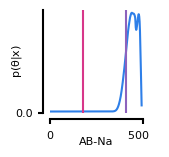

In [70]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname="../../.matplotlibrc"):

    labels_ = get_labels_8pt()
    labels_[9] += ""

    fig, axes = viz.singleOneDmarginal(
        pdfs=[posterior],
        samples=sample_params,
        # subset=[0,1,2,3,4,5,6,7], # ,25,26,28
        subset=[0],  # ,25,26,28
        limits=lims_unnorm,
        ticks=lims_unnorm,
        tick_labels=all_labels,
        fig_size=(1.2, 1.3),
        labels=labels_,
        points=[condition1, bad_condition],
        scatter_offdiag={"rasterized": True, "alpha": 1.0},
        # points_offdiag={'marker':'o', 'markeredgecolor':'w', 'markersize':3.6, 'markeredgewidth':0.5, 'path_effects':[pe.Stroke(linewidth=1.2, foreground='k'), pe.Normal()]},
        points_colors=[col["CONSISTENT1"], col["INCONSISTENT"]],
        samples_colors=[col["SNPE"]],
        condition=torch.as_tensor(condition1_norm, dtype=torch.float32),
        diag=["cond"],
        upper=["cond"],
        hist_offdiag={"bins": 500},
        hist_diag={"bins": 500},
    )
    plt.savefig(PANEL_B0, facecolor='None', transparent=True)
    plt.show()

### Compute the energy to be saved from moving in 1D

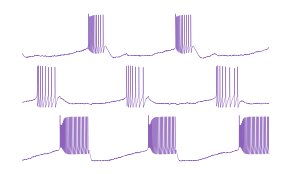

In [71]:
out_target = simulate(deepcopy(condition1), seed=0)

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(3.5, 2.0))
    fig = viz.vis_sample_plain(
        out_target,
        get_time(),
        ax,
        time_len=120000,
        offset=40000,
        col=col["CONSISTENT1"],
        scale_bar=False,
    )
    plt.savefig(PANEL_suppA_traces, facecolor='None', transparent=True)
    plt.show()

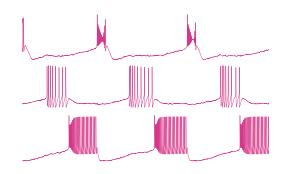

In [72]:
for sss in range(1):
    out_target = simulate(deepcopy(bad_condition), seed=4) # 6

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(3.5, 2.0))
        fig = viz.vis_sample_plain(
            out_target,
            get_time(),
            ax,
            time_len=120000,
            col=col["INCONSISTENT"],
            offset=300000,
            scale_bar=False,
        )
        plt.savefig(PANEL_suppB_traces, facecolor='None', transparent=True)
        plt.show()

# Panel B: cure the parameter set

In [73]:
bad_condition

array([ 1.1300000e-01,  3.3115612e-03,  3.2693320e-03,  3.6443472e-02,
        5.9084450e-03,  3.9999999e-02,  3.8487840e-08,  3.8131582e-06,
        8.2711510e-02,  8.5804779e-05,  3.3336091e-03,  1.6878523e-02,
        2.7088188e-03,  3.0673232e-02,  2.0099101e-06,  2.3677630e-05,
        2.2868732e-01,  7.3361900e-03,  1.7210880e-03,  2.2742176e-02,
        2.8368359e-04,  6.9615543e-02,  1.9071629e-05,  1.8383736e-05,
       -1.7186108e+01, -1.1648663e+01, -1.0445819e+01, -8.6075382e+00,
       -1.0597688e+01, -1.7503933e+01, -1.0859852e+01], dtype=float32)

In [74]:
cured_condition = deepcopy(bad_condition)
cured_condition[5] = 0.087 # 0.087

In [75]:
def revert_positions(a):
    """
    Because we swap the dimensions of the two parameters (such that LP-CaS is on the x-axis), we also have to flip these values for the points.
    """
    a_new = deepcopy(a)
    a_new[5] = deepcopy(a[0])
    a_new[0] = deepcopy(a[5])
    return a_new

In [76]:
from decimal import Decimal

all_labels = []
for dim_i in range(31):
    if dim_i > len(params_mean) - 7.5:  # synapses
        if dim_i == 24:
            all_labels.append(
                [r"$\mathdefault{0.01}$   ", r"$\mathdefault{10000}$   "]
            )
        else:
            all_labels.append(
                [r"$\;\;\mathdefault{0.01}$", r"$\mathdefault{1000}$ "]
            )
    else:  # membrane conductances
        num_after_digits = -int(
            np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i])
        )
        if num_after_digits > 2:
            num_after_digits = 2
        labels = [
            round(
                Decimal(
                    (lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i])
                    / 0.628e-3
                ),
                num_after_digits,
            )
            for num_tmp in range(2)
        ]
        new_labels = []
        counter = 0
        for l in labels:
            if counter == 0:
                new_labels.append(r"$\mathdefault{" + str(int(l)) + "}$")
            else:
                new_labels.append(r"$\mathdefault{" + str(int(l)) + "}$")
            counter += 1
        all_labels.append(new_labels)

/home/michael/Documents/STG_energy/stg_energy/fig5_cc/viz.py:640: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


running this upper


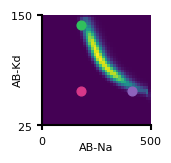

In [77]:
# condition1_swap = revert_positions(condition1)
# bad_condition_swap = revert_positions(bad_condition)
# cured_condition_swap = revert_positions(cured_condition)

with mpl.rc_context(fname="../../.matplotlibrc"):

    labels_ = get_labels_8pt()
    labels_[9] += ""

    fig, axes = viz.single2Dmarginal(
        pdfs=[posterior],
        samples=sample_params,
        subset=[5, 0],  # 0,1   0,4    0,5
        #subset=[0,5],  # 0,1   0,4    0,5
        limits=lims_unnorm,
        ticks=lims_unnorm,
        tick_labels=all_labels,
        fig_size=(1.4, 1.4),
        labels=labels_,
        points=[condition1, bad_condition, cured_condition],
        scatter_offdiag={"rasterized": True, "alpha": 1.0},
        points_offdiag={'markersize':12.6},
        points_colors=[col["CONSISTENT1"], col["INCONSISTENT"], col["GT"]],
        samples_colors=[col["SNPE"]],
        condition=torch.as_tensor(condition1_norm, dtype=torch.float32),
        diag=None,
        upper=["cond"],
        hist_offdiag={"bins": 40},
    )

    plt.savefig(PANEL_C0, facecolor='None', transparent=True)
    plt.show()

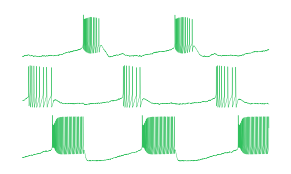

In [78]:
out_target = simulate(deepcopy(cured_condition), seed=0)

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(3.5, 2.0))
    fig = viz.vis_sample_plain(
        out_target, get_time(), ax, time_len=120000, col=col["GT"], offset=45000, scale_bar=False
    )
    plt.savefig(PANEL_suppC_traces, facecolor='None', transparent=True)
    plt.show()

# Panel C: show that energy is not constant in this plane

In [469]:
# pairs = np.asarray(
#     [[0, 2], [4, 5], [10, 11], [11, 12], [17, 18], [18, 19], [22, 26], [24, 25]]
# )  # [18,19]
pairs = np.asarray(
    [[0, 5]]
)  # [18,19]
neuron_to_observe = ["PM", "PM", "LP", "LP", "PY", "PY", "PM", "PM"]

In [470]:
condition1_norm = torch.as_tensor([condition1], dtype=torch.float32)

In [471]:
condition1 = deepcopy(sample_params[sample_number])  # 5,6 is good
condition1_stats = deepcopy(sample_stats[sample_number])
condition1_norm = torch.as_tensor([condition1])

In [472]:
grid_bins = 50
patience = 3

In [473]:
my_samples = posterior.sample(10000)
probs = posterior.log_prob(my_samples).detach().numpy()
sorted_log_probs = np.sort(probs)
threshold_for_simulating = sorted_log_probs[5000] # upper 75% quantile.
threshold_for_simulating = np.exp(threshold_for_simulating-100.) # subtract for numerical stability
print("threshold_for_simulating", threshold_for_simulating)

threshold_for_simulating 5761697579852671.0


In [479]:
vec = np.linspace(-np.sqrt(3), np.sqrt(3), grid_bins)
all_energy_images = []
all_conditional_correlations = []

for counter, pair in enumerate(pairs):
    print("New pair")
    dim1 = pair[0]
    dim2 = pair[1]

    p_vector = eval_conditional_density(
        posterior, condition1_norm, lims_unnorm, dim1, dim2, resolution=50, log=False
    )
    p_vector = p_vector / np.max(p_vector)  # just to scale it to 1

#     # get the minimum requried probability to be simulated
#     min_prob = ue.extract_min_prob(
#         posterior,
#         condition1_norm,
#         grid_bins,
#         dim1,
#         dim2,
#         lims_unnorm,
#         mode="posterior_prob",
#     )
#     min_prob /= 1.5
    
    # correct the limits a bit: when we evaluate exactly at the bounds, it gets 0.0.
    lims_unnorm[:, 0] += 1e-12
    lims_unnorm[:, 1] -= 1e-12
    
    data = np.load(
        "../../results/regression_nets/201007_predict_total_energy_ABPD.npz",
        allow_pickle=True,
    )
    converged_nn = data["converged_nn"].tolist()
    mean_params = torch.as_tensor(data["mean_params"].tolist())
    std_params = torch.as_tensor(data["std_params"].tolist())
    mean_energy = torch.as_tensor(data["mean_energy"].tolist())
    std_energy = torch.as_tensor(data["std_energy"].tolist())

    # get the energies in the conditional plane
    energy_image, energy_image_specific_neuron, _, _ = ue.energy_of_conditional(
        posterior,
        condition1_norm,
        grid_bins,
        threshold_for_simulating,
        dim1,
        dim2,
        lims_unnorm,
        stats_std=stats_std,
        neuron_to_observe=neuron_to_observe[counter],
        patience=patience,
        regression_net=converged_nn,
        neural_net_zscore_mean=mean_params,
        neural_net_zscore_std=std_params,
        neural_net_zscore_mean_energy=mean_energy,
        neural_net_zscore_std_energy=std_energy,
    )
    
    all_conditional_correlations.append(p_vector)
    all_energy_images.append(energy_image)
    
    np.save(f'../../results/conditional_correlation_energy/200930_sample{sample_number}_dims{dim1}_{dim2}_grid{grid_bins}_patience{patience}_p_vector_nn', p_vector)
    np.save(f'../../results/conditional_correlation_energy/200930_sample{sample_number}_dims{dim1}_{dim2}_grid{grid_bins}_patience{patience}_energy_nn', energy_image)
    np.save(f'../../results/conditional_correlation_energy/200930_sample{sample_number}_dims{dim1}_{dim2}_grid{grid_bins}_patience{patience}_energy_specific_neuron_nn', energy_image_specific_neuron)

New pair


In [480]:
all_conditional_correlations = np.load(
    "../../results/conditional_correlation_energy/200930_sample0_dims0_5_grid50_patience3_p_vector_nn.npy"
)
all_energy_images = np.load(
    "../../results/conditional_correlation_energy/200930_sample0_dims0_5_grid50_patience3_energy_specific_neuron_nn.npy"
)

In [481]:
# all_conditional_correlations = np.load(
#     "../../results/conditional_correlation_energy/200930_dim10_dim25_grid50_patience3_p_vector.npy"
# )
# all_energy_images = np.load(
#     "../../results/conditional_correlation_energy/200930_dim10_dim25_grid50_patience3.npy"
# )

In [482]:
all_conditional_correlations = np.asarray(all_conditional_correlations)
energy_image = np.asarray(all_energy_images)

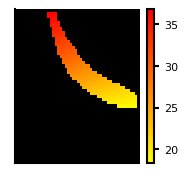

In [483]:
# build colormap
colors = plt.cm.autumn(np.linspace(0, 1, 2048))
blacks = np.ones_like(colors)
blacks[:, :3] = 0.0

# combine them and build a new colormap
colors = np.vstack((blacks[-1], np.flipud(colors)))
mymap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

image = deepcopy(energy_image / 40000)
# image[image == 0.0] = np.max(image) + 1.0
max_val_of_image = np.max(image[image != np.max(image)])
min_val_of_image = np.min(image[image != np.min(image)])
diff = max_val_of_image - min_val_of_image
val_for_black_parts = min_val_of_image - 1/200*diff
image[image == np.min(image)] = val_for_black_parts
val_for_white_parts = max_val_of_image + 1/200*diff
image[image == np.max(image)] = val_for_white_parts

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    h = ax.imshow(image, origin="lower", aspect="auto", cmap=mymap)
    plt.colorbar(h)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    plt.show()

In [422]:
# # build colormap
# colors = plt.cm.autumn(np.linspace(0, 1, 2048))
# blacks = np.ones_like(colors)
# blacks[:, :3] = 0.0

# whites = np.zeros_like(colors)
# whites[:, :3] = 0.0

# # combine them and build a new colormap
# colors = np.vstack((blacks[-1], np.flipud(colors), whites[-1]))
# mymap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

# image = deepcopy(energy_image / 40000)
# image[image == 0.0] = np.max(image) + 1.0
# max_val_of_image = np.max(image[image != np.max(image)])
# min_val_of_image = np.min(image[image != np.min(image)])
# diff = max_val_of_image - min_val_of_image
# val_for_black_parts = min_val_of_image - 1/200*diff
# image[image == np.min(image)] = val_for_black_parts
# val_for_white_parts = max_val_of_image + 1/200*diff
# image[image == np.max(image)] = val_for_white_parts

# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(2, 2))
#     h = ax.imshow(image, origin="lower", aspect="auto", cmap=mymap)
#     plt.colorbar(h)
#     ax.axes.get_yaxis().set_ticks([])
#     ax.axes.get_xaxis().set_ticks([])
#     plt.show()

In [423]:
pairs

array([[0, 5]])

In [424]:
neurons = ["AB/PD1", "AB/PD2", "LP1", "LP2", "PY1", "PY2", "syn1", "syn2"]

seeds_max = [0, 0, 0, 1, 0, 0, 0, 0]
seeds_min = [0, 0, 1, 1, 0, 0, 0, 0]

t_max_mins = [125000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_max_maxs = [145000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

t_min_mins = [120000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_min_maxs = [140000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

neuron_to_plot = [0, 0, 1, 1, 2, 2, 2, 0]

set_to_inspect = 0

# find dims
# energy_image = all_energy_images[set_to_inspect]
pair = pairs[set_to_inspect]
dim1 = pair[0]
dim2 = pair[1]

vec1 = np.linspace(lims_unnorm[dim1, 0], lims_unnorm[dim1, 1], grid_bins)
vec2 = np.linspace(lims_unnorm[dim2, 0], lims_unnorm[dim2, 1], grid_bins)

In [425]:
np_pair = np.asarray(pair)
labels = get_labels_8pt()
labels_for_x_and_y = labels[np_pair]

-------- High energy set --------


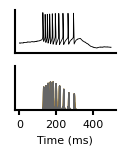

In [426]:
###################################################################################################
#                                        maximum energy set                                       #
###################################################################################################

print("-------- High energy set --------")
cond1_norm_tmp = deepcopy(condition1_norm[0])
tmp_energy_image = deepcopy(energy_image)
# find parameter value that had maximum energy
max_energy_pixel = np.unravel_index(tmp_energy_image.argmax(), tmp_energy_image.shape)
# replace the parameter values
param1 = vec1[max_energy_pixel[0]]
param2 = vec2[max_energy_pixel[1]]

cond1_norm_tmp[dim1] = param1
cond1_norm_tmp[dim2] = param2

# simulate and build energy scape
parameter_set = cond1_norm_tmp

out_target = simulate_energyscape(deepcopy(parameter_set), seed=8607175)

with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        out_target,
        get_time(),
        figsize=(1.3, 1.3),
        cols=['k', 'k', 'k'],
        time_len=20000,
        offset=155000,
        neuron=neuron_to_plot[set_to_inspect],
        ylabels=False,
    )
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

In [427]:
max_energy_pixel

(48, 13)

-------- Low energy set --------


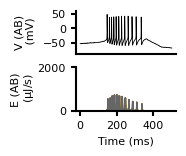

In [428]:
###################################################################################################
#                                        minimum energy set                                       #
###################################################################################################
print("-------- Low energy set --------")
tmp_energy_image = deepcopy(energy_image)
tmp_energy_image[tmp_energy_image <=0.0] = 1e10
min_energy_pixel = np.unravel_index(tmp_energy_image.argmin(), tmp_energy_image.shape)
param1 = vec1[min_energy_pixel[0]]
param2 = vec2[min_energy_pixel[1]]

cond1_norm_tmp[dim1] = param1
cond1_norm_tmp[dim2] = param2

parameter_set = cond1_norm_tmp

out_target = simulate_energyscape(deepcopy(parameter_set), seed=8607175)
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        out_target,
        get_time(),
        figsize=(1.3, 1.3),
        cols=['k', 'k', 'k'],
        time_len=20000,
        offset=301300,
        neuron=neuron_to_plot[set_to_inspect],
        ylabels=True,
    )
    plt.savefig(PANEL_C3, facecolor='None', transparent=True)
    plt.show()

# Plot the figure again, but with the points of max and min

In [429]:
from pyloric.sbi_prior import create_prior
prior = create_prior()

In [430]:
lower0 = prior.support.lower_bound[pairs[set_to_inspect][0]].item() / 0.628e-3
upper0 = prior.support.upper_bound[pairs[set_to_inspect][0]].item() / 0.628e-3
lower1= prior.support.lower_bound[pairs[set_to_inspect][1]].item() / 0.628e-3
upper1 = prior.support.upper_bound[pairs[set_to_inspect][1]].item() / 0.628e-3

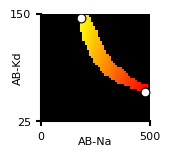

In [560]:
# build colormap
colors = plt.cm.autumn(np.linspace(0, 1, 2048))
blacks = np.ones_like(colors)
blacks[:, :3] = 0.0

# combine them and build a new colormap
colors = np.vstack((blacks[-1], np.flipud(colors)))
mymap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

image = deepcopy(energy_image / 40000)
max_val_of_image = np.max(image[image != np.max(image)])
min_val_of_image = np.min(image[image != np.min(image)])
diff = max_val_of_image - min_val_of_image
val_for_black_parts = min_val_of_image - 1/200*diff
image[image == np.min(image)] = val_for_black_parts

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
    h = ax.imshow(image.T, origin="lower", aspect="auto", cmap=mymap)
    ax.scatter(min_energy_pixel[0], min_energy_pixel[1]-0.5, s=40, color='#FFFFFF', edgecolors='k', linewidths=0.8)
    # -0.5 because otherwise the dot is cut off.
    ax.scatter(max_energy_pixel[0]-0.5, max_energy_pixel[1], s=40, color='#FFFFFF', edgecolors='k', linewidths=0.8)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
#     ax.spines['top'].set_visible(True)
#     ax.spines['right'].set_visible(True)
    ax.set_xlabel(labels_for_x_and_y[0], labelpad=-3)
    ax.set_ylabel(labels_for_x_and_y[1], labelpad=-9)
    ax.set_xticks([-0.5, image.shape[0]-0.5])
    ax.set_yticks([-0.5, image.shape[1]-0.5])
    ax.set_xticklabels([int(np.round(lower0)), int(np.round(upper0))])
    ax.set_yticklabels([int(np.round(lower1)), int(np.round(upper1))])
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

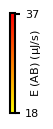

In [565]:
with mpl.rc_context(fname="../../.matplotlibrc"):

    # draw a new figure and replot the colorbar there
    fig, ax = plt.subplots(figsize=(1.3, 1.3))
    cbar = plt.colorbar(h)
    cbar.set_ticks([val_for_black_parts, max_val_of_image])
    cbar.set_ticklabels(['%.0f' %val_for_black_parts, '%.0f' %max_val_of_image])
    cbar.set_label("E (AB) ($\mu$J/s)", labelpad=-7)

    ax.remove()
    plt.savefig(PANEL_C_CBAR, facecolor='None', transparent=True)
    plt.show()

# Panel D: summarize the energy gains in matrizes

### AB/PD

In [521]:
condition1_original = deepcopy(sample_params[sample_number])  # 5,6 is good
condition1_stats_original = deepcopy(sample_stats[sample_number])
condition1_norm_original = torch.as_tensor([condition1_original])

In [522]:
sample_seed[0]

8607175

In [523]:
# data = np.load(
#     "../../results/regression_nets/201007_predict_total_energy_ABPD.npz",
#     allow_pickle=True,
# )
# converged_nn = data["converged_nn"].tolist()
# mean_params = torch.as_tensor(data["mean_params"].tolist())
# std_params = torch.as_tensor(data["std_params"].tolist())
# mean_energy = torch.as_tensor(data["mean_energy"].tolist())
# std_energy = torch.as_tensor(data["std_energy"].tolist())

# (
#     all_conditional_correlations,
#     all_energy_images,
#     all_energy_specific,
#     all_energy_per_spike,
#     all_num_spikes_per_burst,
# ) = helpers.generate_and_store_data(
#     neuron1=np.arange(8),
#     neuron2=np.arange(8),
#     neuron_to_observe='PM',
#     grid_bins=grid_bins,
#     posterior=posterior,
#     condition1_norm=condition1_norm_original,
#     lims_unnorm=lims_unnorm,
#     stats_std=stats_std,
#     regression_net=converged_nn,
#     neural_net_zscore_mean=mean_params,
#     neural_net_zscore_std=std_params,
#     neural_net_zscore_mean_energy=mean_energy,
#     neural_net_zscore_std_energy=std_energy,
#     min_prob=threshold_for_simulating,
# )

In [524]:
with open(
    "../../results/conditional_correlation_energy/201007_PM_all_stored_data_from_all_energy_specific_nn.pickle",
    "rb",
) as handle:
    all_energy_images_specific = pickle.load(handle)

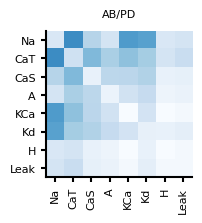

In [525]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_gain_matrix(all_energy_images_specific, figsize=(1.9, 1.9), title="AB/PD", lims=[0,90])
    plt.savefig(PANEL_D1, facecolor='None', transparent=True)
    plt.show()

### LP

In [526]:
# data = np.load(
#     "../../results/regression_nets/201007_predict_total_energy_LP.npz",
#     allow_pickle=True,
# )
# converged_nn = data["converged_nn"].tolist()
# mean_params = torch.as_tensor(data["mean_params"].tolist())
# std_params = torch.as_tensor(data["std_params"].tolist())
# mean_energy = torch.as_tensor(data["mean_energy"].tolist())
# std_energy = torch.as_tensor(data["std_energy"].tolist())

# (
#     all_conditional_correlations,
#     all_energy_images,
#     all_energy_specific,
#     all_energy_per_spike,
#     all_num_spikes_per_burst,
# ) = helpers.generate_and_store_data(
#     neuron1=np.arange(8,16),
#     neuron2=np.arange(8,16),
#     neuron_to_observe='LP',
#     grid_bins=grid_bins,
#     posterior=posterior,
#     condition1_norm=condition1_norm,
#     lims_unnorm=lims_unnorm,
#     stats_std=stats_std,
#     regression_net=converged_nn,
#     neural_net_zscore_mean=mean_params,
#     neural_net_zscore_std=std_params,
#     neural_net_zscore_mean_energy=mean_energy,
#     neural_net_zscore_std_energy=std_energy,
#     min_prob=threshold_for_simulating,
# )

In [527]:
with open(
    "../../results/conditional_correlation_energy/201007_LP_all_stored_data_from_all_energy_specific_nn.pickle",
    "rb",
) as handle:
    all_energy_images_specific = pickle.load(handle)

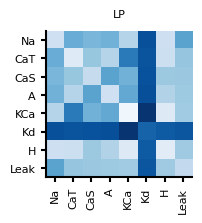

In [528]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_gain_matrix(all_energy_images_specific, figsize=(1.9, 1.9), title="LP", lims=[0., 90.])
    plt.savefig(PANEL_D2, facecolor='None', transparent=True)
    plt.show()

### PY

In [529]:
# data = np.load(
#     "../../results/regression_nets/201007_predict_total_energy_PY.npz",
#     allow_pickle=True,
# )
# converged_nn = data["converged_nn"].tolist()
# mean_params = torch.as_tensor(data["mean_params"].tolist())
# std_params = torch.as_tensor(data["std_params"].tolist())
# mean_energy = torch.as_tensor(data["mean_energy"].tolist())
# std_energy = torch.as_tensor(data["std_energy"].tolist())

# (
#     all_conditional_correlations,
#     all_energy_images,
#     all_energy_specific,
#     all_energy_per_spike,
#     all_num_spikes_per_burst,
# ) = helpers.generate_and_store_data(
#     neuron1=np.arange(16,24),
#     neuron2=np.arange(16,24),
#     neuron_to_observe='PY',
#     grid_bins=grid_bins,
#     posterior=posterior,
#     condition1_norm=condition1_norm,
#     lims_unnorm=lims_unnorm,
#     stats_std=stats_std,
#     regression_net=converged_nn,
#     neural_net_zscore_mean=mean_params,
#     neural_net_zscore_std=std_params,
#     neural_net_zscore_mean_energy=mean_energy,
#     neural_net_zscore_std_energy=mean_energy,
#     min_prob=threshold_for_simulating,
# )

In [530]:
with open(
    "../../results/conditional_correlation_energy/201007_PY_all_stored_data_from_all_energy_specific_nn.pickle",
    "rb",
) as handle:
    all_energy_images = pickle.load(handle)

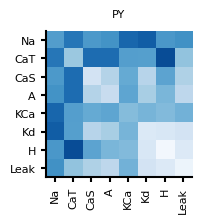

In [531]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    im = viz.energy_gain_matrix(all_energy_images, figsize=(1.9, 1.9), title="PY", lims=[0, 90])
    fig.colorbar(im)
    plt.savefig(PANEL_D3, facecolor='None', transparent=True)
    plt.show()

### Synapses

In [532]:
# data = np.load(
#     "../../results/regression_nets/201007_predict_total_energy_ABPD.npz",
#     allow_pickle=True,
# )
# converged_nn_AB = data["converged_nn"].tolist()
# mean_params = torch.as_tensor(data["mean_params"].tolist())
# std_params = torch.as_tensor(data["std_params"].tolist())
# mean_energy_AB = torch.as_tensor(data["mean_energy"].tolist())
# std_energy_AB = torch.as_tensor(data["std_energy"].tolist())

# data = np.load(
#     "../../results/regression_nets/201007_predict_total_energy_LP.npz",
#     allow_pickle=True,
# )
# converged_nn_LP = data["converged_nn"].tolist()
# mean_energy_LP = torch.as_tensor(data["mean_energy"].tolist())
# std_energy_LP = torch.as_tensor(data["std_energy"].tolist())

# data = np.load(
#     "../../results/regression_nets/201007_predict_total_energy_PY.npz",
#     allow_pickle=True,
# )
# converged_nn_PY = data["converged_nn"].tolist()
# mean_energy_PY = torch.as_tensor(data["mean_energy"].tolist())
# std_energy_PY = torch.as_tensor(data["std_energy"].tolist())

# pairs_syn = np.asarray(
#     [
#         [24, 8],
#         [24, 9],
#         [24, 10],
#         [24, 11],
#         [24, 12],
#         [24, 13],
#         [24, 14],
#         [24, 15],  # LP
#         [25, 8],
#         [25, 9],
#         [25, 10],
#         [25, 11],
#         [25, 12],
#         [25, 13],
#         [25, 14],
#         [25, 15],  # LP
#         [26, 16],
#         [26, 17],
#         [26, 18],
#         [26, 19],
#         [26, 20],
#         [26, 21],
#         [26, 22],
#         [26, 23],  # PY
#         [27, 16],
#         [27, 17],
#         [27, 18],
#         [27, 19],
#         [27, 20],
#         [27, 21],
#         [27, 22],
#         [27, 23],  # PY
#         [28, 0],
#         [28, 1],
#         [28, 2],
#         [28, 3],
#         [28, 4],
#         [28, 5],
#         [28, 6],
#         [28, 7],  # PD
#         [29, 16],
#         [29, 17],
#         [29, 18],
#         [29, 19],
#         [29, 20],
#         [29, 21],
#         [29, 22],
#         [29, 23],  # PY
#         [30, 8],
#         [30, 9],
#         [30, 10],
#         [30, 11],
#         [30, 12],
#         [30, 13],
#         [30, 14],
#         [30, 15],
#     ]  # LP
# )
# neuron_to_observe = ["LP"] * 16 + ["PY"] * 16 + ["PM"] * 8 + ["PY"] * 8 + ["LP"] * 8

# (
#     all_conditional_correlations,
#     all_energy_images,
#     all_energy_specific,
#     all_energy_per_spike,
#     all_num_spikes_per_burst,
# ) = helpers.generate_and_store_data(
#     pairs=pairs_syn,
#     neuron1=np.arange(16,24),
#     neuron2=np.arange(16,24),
#     neuron_to_observe=neuron_to_observe,
#     grid_bins=grid_bins,
#     posterior=posterior,
#     condition1_norm=condition1_norm,
#     lims_unnorm=lims_unnorm,
#     stats_std=stats_std,
#     store_as='Synapses',
#     neural_net_zscore_mean=mean_params,
#     neural_net_zscore_std=std_params,
#     net1=converged_nn_AB,
#     mean1=mean_energy_AB,
#     std1=std_energy_AB,
#     net2=converged_nn_LP,
#     mean2=mean_energy_LP,
#     std2=std_energy_LP,
#     net3=converged_nn_PY,
#     mean3=mean_energy_PY,
#     std3=std_energy_PY,
#     min_prob=threshold_for_simulating,
# )

In [533]:
with open(
    "../../results/conditional_correlation_energy/201007_Synapses_all_stored_data_from_all_energy_specific_nn.pickle",
    "rb",
) as handle:
    all_energy_images = pickle.load(handle)

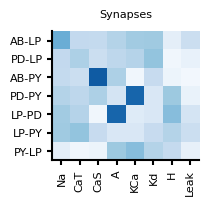

In [534]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    im = viz.energy_gain_matrix_syn(
        all_energy_images, figsize=(1.9, 1.9), title="Synapses", lims=[0, 90]
    )
    fig.colorbar(im)
    plt.savefig(PANEL_D4, facecolor='None', transparent=True)
    plt.show()

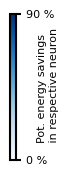

In [553]:
with mpl.rc_context(fname="../../.matplotlibrc"):

    # draw a new figure and replot the colorbar there
    fig, ax = plt.subplots(figsize=(1.9, 1.9))
    cb = plt.colorbar(im, ax=ax, aspect=25)

    # cb.outline.set_color('white')

    cb.outline.set_edgecolor("k")
    #cb.outline.set_linewidth(0.2)

    cb.set_ticks([0.0, 90])  # vertically oriented colorbar
    cb.ax.set_yticklabels(["0 %", "90 %"])  # vertically oriented colorbar

    cb.ax.set_ylabel("Pot. energy savings \n in respective neuron")
    cb.ax.yaxis.labelpad = -12

    ax.remove()
    plt.savefig(PANEL_D5, facecolor='None', transparent=True)
    plt.show()

# Assemble figure

In [536]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [566]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_white = {'size': '7.7pt', 'font': 'Arial', 'color': '#FFFFFF'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "9.3cm",

   Panel(
        SVG(PANEL_B0).scale(svg_scale),
        Text("a", 1.3*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(-1.3*factor_svg, 1.5*factor_svg),
               
    Panel(
        SVG(PANEL_C0).scale(svg_scale),
        Text("b", -0.8*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(25.3*factor_svg, 1.0*factor_svg),
           
    Panel(
        SVG(PANEL_C1).scale(svg_scale),
        Text("c", -1*factor_svg, 1.3*factor_svg, **kwargs_text),
        Text("d", 11.2*factor_svg, 4.0*factor_svg, **kwargs_text8pt_white),
        Text("e", 23.0*factor_svg, 17.3*factor_svg, **kwargs_text8pt_white),
    ).move(54*factor_svg, 1.2*factor_svg),
    
    Panel(
        SVG(PANEL_C_CBAR).scale(svg_scale),
    ).move(78.5*factor_svg, 2.1*factor_svg),
    
    Panel(
        SVG(PANEL_C3).scale(svg_scale),
        Text("d", -1*factor_svg, 0.5*factor_svg, **kwargs_text),
    ).move(91*factor_svg, 2.3*factor_svg),
           
    Panel(
        SVG(PANEL_C2).scale(svg_scale),
        Text("e", -1*factor_svg, 0.5*factor_svg, **kwargs_text),
    ).move(120*factor_svg, 2.3*factor_svg),
    
    Panel(
        SVG(PANEL_D1).scale(svg_scale),
        Text("f", 0*factor_svg, 2*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 29*factor_svg),
    
    Panel(
        SVG(PANEL_D2).scale(svg_scale),
    ).move(32*factor_svg, 29*factor_svg),
    
    Panel(
        SVG(PANEL_D3).scale(svg_scale),
    ).move(64*factor_svg, 29*factor_svg),
    
    Panel(
        SVG(PANEL_D4).scale(svg_scale),
    ).move(96*factor_svg, 31.7*factor_svg),
    
    Panel(
        SVG(PANEL_D5).scale(svg_scale),
    ).move(129.7*factor_svg, 31.6*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig5_reduced.svg")
svg('../fig/fig5_reduced.svg')

### Assemble supplementary

In [1060]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_white = {'size': '7.7pt', 'font': 'Arial', 'color': '#FFFFFF'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "4.3cm",

   Panel(
        SVG(PANEL_suppA_traces).scale(svg_scale),
        Text("a", 0*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 1.5*factor_svg),
               
    Panel(
        SVG(PANEL_suppB_traces).scale(svg_scale),
        Text("b", -0.8*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(48.*factor_svg, 1.0*factor_svg),
           
    Panel(
        SVG(PANEL_suppC_traces).scale(svg_scale),
        Text("c", -0.8*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(96.*factor_svg, 1.0*factor_svg),
           
)

!mkdir -p fig
f.save("../fig/fig5_supp_traces.svg")
svg('../fig/fig5_supp_traces.svg')

# Old stuff

### All 8 conditional correlations

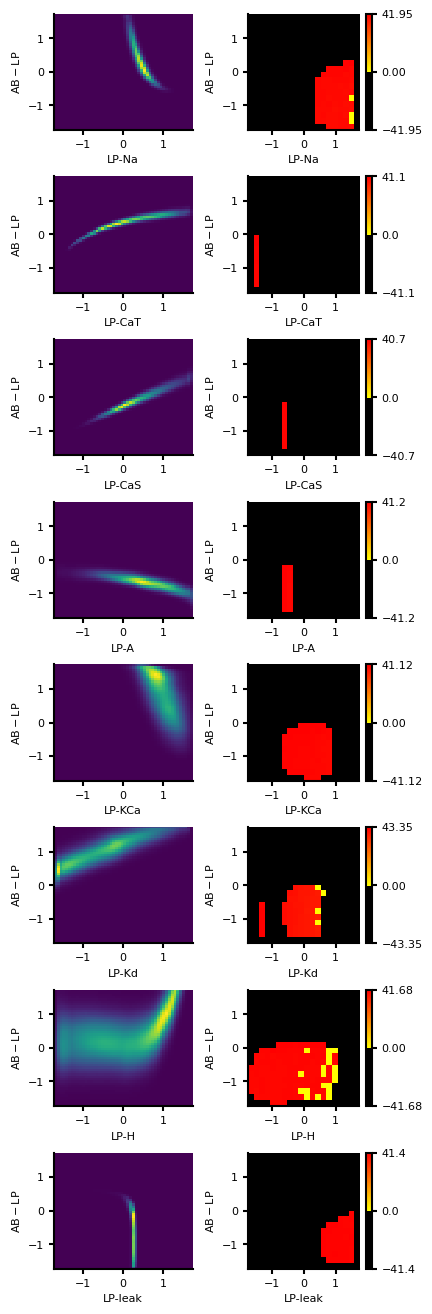

In [331]:
# build colormap
colors = plt.cm.autumn(np.linspace(0, 1, 128))
whites = np.ones_like(colors)
whites[:, :3] = 0.0

# combine them and build a new colormap
colors = np.vstack((whites, np.flipud(colors)))
mymap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
index = 0

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(8, 2, figsize=(4.3, 16.3))

    for condCorr, energy in zip(all_conditional_correlations, all_energy_images):

        energy = energy / 100000
        pair = pairs[index]
        dim1 = pair[0]
        dim2 = pair[1]

        # plotting conditional correlations
        _ = ax[index, 0].imshow(
            condCorr,
            origin="lower",
            extent=[lims[dim1, 0], lims[dim1, 1], lims[dim2, 0], lims[dim2, 1]],
            aspect="auto",
        )
        ax[index, 0].set_xlabel(labels_[dim2])
        ax[index, 0].set_ylabel(labels_[dim1])

        # plotting the energy
        h = ax[index, 1].imshow(
            energy,
            origin="lower",
            extent=[lims[dim1, 0], lims[dim1, 1], lims[dim2, 0], lims[dim2, 1]],
            aspect="auto",
            cmap=mymap,
        )
        cbar = fig.colorbar(
            h,
            ax=ax[index, 1],
            ticks=[
                np.min(energy),
                (np.max(energy) + np.min(energy)) / 2,
                np.max(energy),
            ],
        )

        str1 = str(round(float((np.max(energy) + np.min(energy)) / 2), 2))
        str2 = str(round(float(np.max(energy)), 2))

        # cbar.ax.set_yticklabels(['/', str1, str2])  # vertically oriented colorbar

        ax[index, 1].set_xlabel(labels_[dim2])
        ax[index, 1].set_ylabel(labels_[dim1])

        index += 1

    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # plt.savefig('../results/energy/figs_new/energy_heatmap_full_rejectionNew.png', dpi=300, bbox_inches='tight')

    plt.show()

# Compute the energy-scape for the min and max of the sample

In [72]:
condition1_norm = condition1

In [74]:
def plot_energy_scape(
    pyloric_sim, parameter_set, neuron_to_plot, t_min, t_max, seed, index, minmax
):
    # print('parameter_set', parameter_set)
    out_target = pyloric_sim[0].gen_single(
        deepcopy(parameter_set), seed_sim=True, to_seed=8607175
    )  # params.true_params gives the synaptic strengths #  165000
    ss = energy_calc.calc([out_target])[0]
    # print('First 4 summstats:  ', ss[:4])
    # print('energies', np.sum(out_target['energy'][:,40000:], axis=1)/10000)
    print(offsets[all_counter])
    # fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, parameter_set, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params,
    #                             offset_labels=1000, with_ss=False, time_len=500000, fontscale=1.2, linescale=1.2, legend=False, offset=165000,
    #                             mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
    # plt.show()
    # build energyscape
    all_energies = out_target["all_energies"]
    all_currents_PD = all_energies[:, neuron_to_plot, :]
    zero_val = np.zeros_like(all_currents_PD)
    t = pyloric_sim_11[0].t[0 : t_max - t_min]

    fig, ax = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={"height_ratios": [3, 1]})
    for i in range(8):
        # ax[0].plot(t, all_currents_PD[i,t_min:t_max])
        summed_currents_until = np.sum(all_currents_PD[:i, t_min:t_max], axis=0)
        summed_currents_include = np.sum(all_currents_PD[: i + 1, t_min:t_max], axis=0)
        ax[0].fill_between(
            t, summed_currents_until, summed_currents_include, color=cols_hex[i]
        )

    ax[0].set_ylim([0, 150])
    ax[1].plot(t, out_target["data"][neuron_to_plot, t_min:t_max])
    ax[1].set_ylim([-80, 70])

    # print('summed_currents_include', np.sum(summed_currents_include))

    for a in ax:
        a.set_ylabel("Energy", fontsize=12.0)
        if a == ax[1]:
            a.set_xlabel("Time (ms)", fontsize=12.0)
        a.tick_params(axis="both", which="major", labelsize=12)
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

    ax[0].axes.get_xaxis().set_ticks([])
    ax[1].set_ylabel("Voltage", fontsize=12.0)

    plt.show()

====================== AB/PD1 =====================
-------- High energy set --------
95000


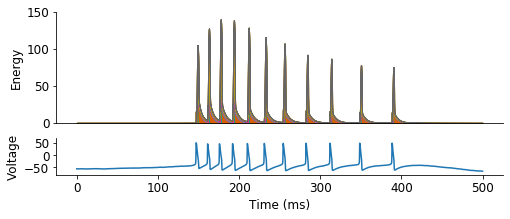

-------- Low energy set --------
95000


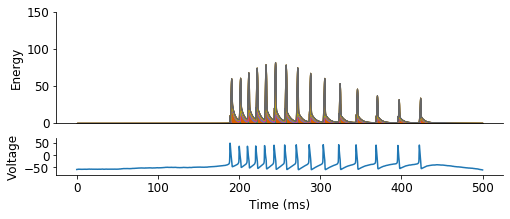

max_energy_pixel (41, 28) min_energy_pixel (21, 33)
====================== AB/PD2 =====================
-------- High energy set --------
95000


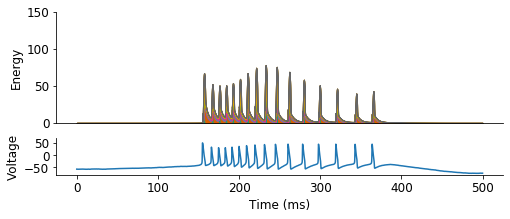

-------- Low energy set --------
95000


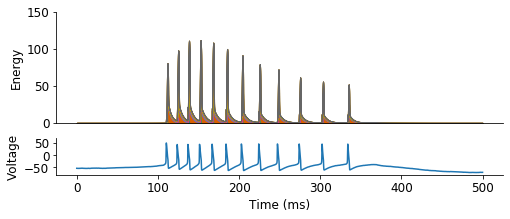

max_energy_pixel (23, 10) min_energy_pixel (34, 47)
====================== LP1 =====================
-------- High energy set --------
95000


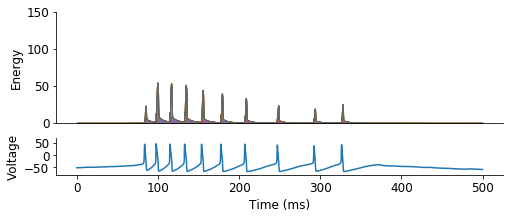

-------- Low energy set --------
95000


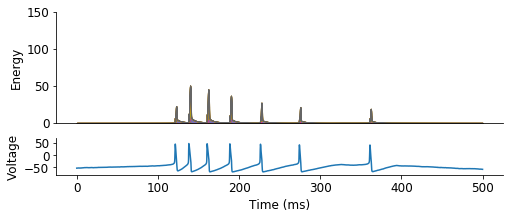

max_energy_pixel (26, 31) min_energy_pixel (18, 23)
====================== LP2 =====================
-------- High energy set --------
95000


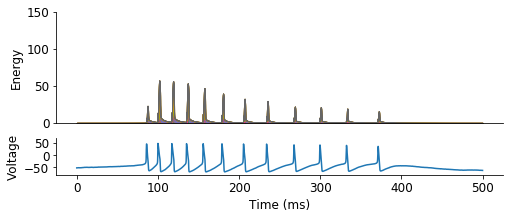

-------- Low energy set --------
95000


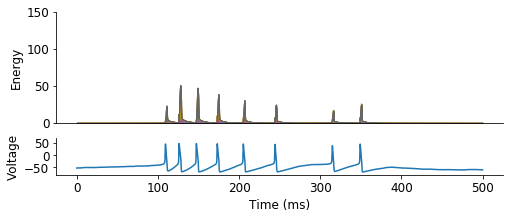

max_energy_pixel (9, 48) min_energy_pixel (18, 31)
====================== PY1 =====================
-------- High energy set --------
95000


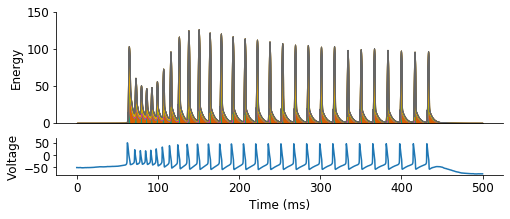

-------- Low energy set --------
95000


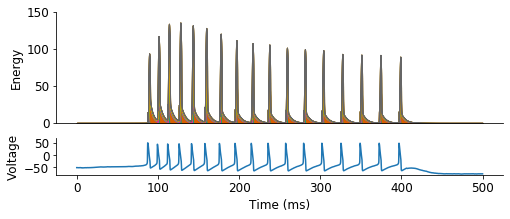

max_energy_pixel (46, 40) min_energy_pixel (22, 42)
====================== PY2 =====================
-------- High energy set --------
95000


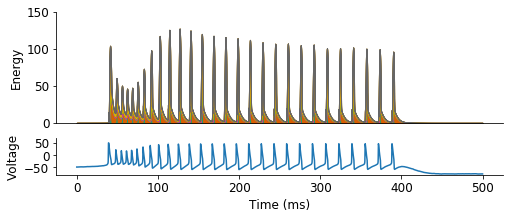

-------- Low energy set --------
95000


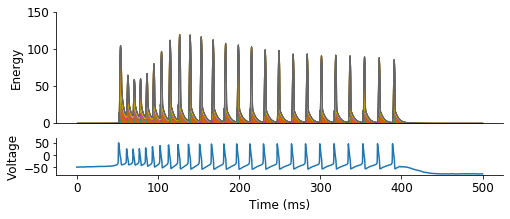

max_energy_pixel (36, 1) min_energy_pixel (48, 45)
====================== syn1 =====================
-------- High energy set --------
95000


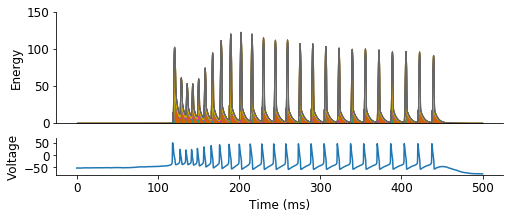

-------- Low energy set --------
95000


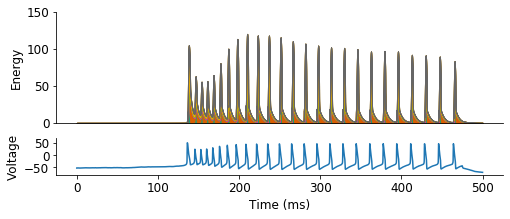

max_energy_pixel (29, 28) min_energy_pixel (39, 46)
====================== syn2 =====================
-------- High energy set --------
95000


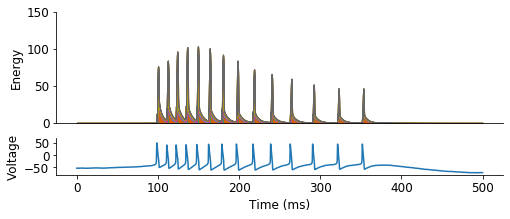

-------- Low energy set --------
95000


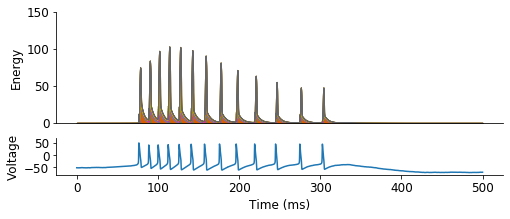

max_energy_pixel (27, 28) min_energy_pixel (5, 28)


In [75]:
cols_hex = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
]
t_min = 72000
t_max = 100000

neurons = ["AB/PD1", "AB/PD2", "LP1", "LP2", "PY1", "PY2", "syn1", "syn2"]

seeds_max = [0, 0, 0, 1, 0, 0, 0, 0]
seeds_min = [0, 0, 1, 1, 0, 0, 0, 0]

t_max_mins = [125000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_max_maxs = [145000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

t_min_mins = [120000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_min_maxs = [140000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

neuron_to_plot = [0, 0, 1, 1, 2, 2, 2, 0]

for index, energy_image in enumerate(all_energy_images):

    print("======================", neurons[index], "=====================")
    # find dims
    pair = pairs[index]
    dim1 = pair[0]
    dim2 = pair[1]

    vec1 = np.linspace(lims_unnorm[dim1, 0], lims_unnorm[dim1, 1], grid_bins)
    vec2 = np.linspace(lims_unnorm[dim2, 0], lims_unnorm[dim2, 1], grid_bins)

    ###################################################################################################
    #                                        maximum energy set                                       #
    ###################################################################################################

    print("-------- High energy set --------")
    cond1_norm_tmp = deepcopy(condition1_norm)
    tmp_energy_image = deepcopy(energy_image)
    # find parameter value that had maximum energy
    max_energy_pixel = np.unravel_index(
        tmp_energy_image.argmax(), tmp_energy_image.shape
    )

    # replace the parameter values
    param1 = vec1[max_energy_pixel[0]]
    param2 = vec2[max_energy_pixel[1]]

    cond1_norm_tmp[dim1] = param1
    cond1_norm_tmp[dim2] = param2

    # simulate and build energy scape
    parameter_set = cond1_norm_tmp
    plot_energy_scape(
        pyloric_sim,
        parameter_set,
        neuron_to_plot[index],
        t_max_mins[index],
        t_max_maxs[index],
        seeds_max[index],
        index,
        "max",
    )

    ###################################################################################################
    #                                        minimum energy set                                       #
    ###################################################################################################
    print("-------- Low energy set --------")
    cond1_norm_tmp = deepcopy(condition1_norm)
    tmp_energy_image = deepcopy(energy_image)
    tmp_energy_image[tmp_energy_image == np.min(tmp_energy_image)] = 1e10
    min_energy_pixel = np.unravel_index(
        tmp_energy_image.argmin(), tmp_energy_image.shape
    )

    param1 = vec1[min_energy_pixel[0]]
    param2 = vec2[min_energy_pixel[1]]

    cond1_norm_tmp[dim1] = param1
    cond1_norm_tmp[dim2] = param2

    parameter_set = cond1_norm_tmp
    plot_energy_scape(
        pyloric_sim,
        parameter_set,
        neuron_to_plot[index],
        t_min_mins[index],
        t_min_maxs[index],
        seeds_min[index],
        index,
        "min",
    )

    plt.show()

    print("max_energy_pixel", max_energy_pixel, "min_energy_pixel", min_energy_pixel)